### Python packages used in this code

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import sklearn
import platform
import sys
from sklearn.base import BaseEstimator, RegressorMixin
import seaborn as sns

%matplotlib inline

In [2]:
"""
Environments

--Platform--
OS : Windows-10-10.0.19044-SP0
--Version--
python :  3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
numpy : 1.23.1
pandas : 1.4.3
sklearn : 1.1.1
seaborn : 0.11.2
"""

print('--Platform--')
print('OS :', platform.platform())
print('--Version--')
print('python : ', sys.version)
print('numpy :', np.__version__)
print('pandas :', pd.__version__)
print('sklearn :', sklearn.__version__)
print('seaborn :', sns.__version__)

--Platform--
OS : Windows-10-10.0.19044-SP0
--Version--
python :  3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
numpy : 1.23.1
pandas : 1.4.3
sklearn : 1.1.1
seaborn : 0.11.2


# Preparation

## Create output directories

In [3]:
if not os.path.isdir('../30_Output/10_Model/400_MakeResult'):
    os.makedirs('../30_Output/10_Model/400_MakeResult')
if not os.path.isdir('../30_Output/20_Plot/400_MakeResult'):
    os.makedirs('../30_Output/20_Plot/400_MakeResult')
if not os.path.isdir('../30_Output/30_csv/400_MakeResult'):
    os.makedirs('../30_Output/30_csv/400_MakeResult')
if not os.path.isdir('../30_Output/40_pkl/400_MakeResult'):
    os.makedirs('../30_Output/40_pkl/400_MakeResult')

### Model class

In [4]:
class cls_FusedRidge(BaseEstimator, RegressorMixin):
    def __init__(self, lambda_scale=1, lambda_trend=1):
        """
        Define the model class for log-difference model
        
        Parameters
        ----------
            lambda_scale : reguralization parameter for the scale of gamma
            lambda_trend : reguralization parameter for the trend of gamma
        """
        self.lambda_scale = lambda_scale
        self.lambda_trend = lambda_trend
    
    def make_D(self, n_features):
        trend_matrix = np.eye(n_features - 1, n_features, k=1) - np.eye(n_features - 1, n_features)
        trend_matrix[[9, 29, 49, 69, 89, 109, 129, 149, 169]] = np.zeros(n_features)
        
        if self.lambda_scale == 0:
            return self.lambda_trend * trend_matrix
        elif self.lambda_trend == 0:
            return self.lambda_scale * np.identity(n_features)
        else:
            generated = np.vstack([self.lambda_scale * np.identity(n_features),
                                   self.lambda_trend * trend_matrix])
            return generated
        
    def fit(self, X, y=None):
        """
        Model fitting
        
        Required grobal variables
        -----------------------
        
        Returns
        -------

        """
        # dataset
        self.X = X
        self.y = y
        
        # dimension
        self.n_sample, self.dim_X = self.X.shape
        
        # Matrices
        self.D = self.make_D(self.dim_X)
        self.D2 = np.transpose(self.D).dot(self.D)
        
        # Fit
        self.intercept = np.mean(self.y)
        self.theta = np.linalg.pinv(self.X.T.dot(self.X) + self.D2).dot(self.X.T).dot(self.y-self.intercept)

        return self
    
    def predict(self, X):
        """
        Prediction function
            
        Returns
        -------
        """
        return X.dot(self.theta) + self.intercept

    def score(self, X, y=None):
        """
        Score function for cross-validation
        
        Returns
        -------
            -\sum(y-\hat{y})/n (Consider the minus value because 'GridSearchCV' maximize the score.)
        """
        return -sum((y.values - self.predict(X).values)**2)/self.n_sample
    
    def get_params(self, deep=True):
        """
        Create parameter dictionary for cross-validation
        
        Returns
        -------
        """
        return {'lambda_scale' : self.lambda_scale,
                'lambda_trend' : self.lambda_trend}
    
    def set_params(self, **parameters):
        """
        For cross-validation
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self     

In [5]:
class cls_InvTrans_FR(BaseEstimator, RegressorMixin):
    def __init__(self, lambda1=1, lambda2=1, lambda3_scale=1, lambda3_trend=1):
        """
        Define the model class proposed in the paper
            h(x) = \alpha_1*ys + \alpha_0 + (\beta*ys + 1)<\gamma, x>
                x  : discriptor
                ys : CP(MD)
        
        Parameters
        ----------
            lambda1       : regularization parameter for alpha
            lambda2       : regularization parameter for beta
            lambda3_scale : reguralization parameter for the scale of gamma
            lambda3_trend : reguralization parameter for the trend of gamma
        """
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3_scale = lambda3_scale
        self.lambda3_trend = lambda3_trend
    
    def estimation_alpha(self):
        """
        Optimization with respect to alpha
            [\hat{\alpha}_1, \hat{\alpha}_2]^T 
                = (Ys^TYs + n\Lambda_1)^{-1} Ys^T (y + (\beta*ys+1)*<\gamma, x>)
            
                    Ys = | ys_1  1 | \in R^{n*2}, \Lambda_1 = | \lambda1  0 |, ys = | ys_1 |
                         | ys_2  1 |                          |        0  0 |       | ys_2 |
                              :                                                     |   :  |
                         | ys_n  1 |                                                | ys_n |
                         
        Note that the regularization applies only to \alpha_1 and not to the intercept \alpha_1.
        """
        self.alpha = self.InvMat.dot(self.X_source1.T).dot(self.y + (self.Mat2+1)*(self.Mat3))
        self.Mat1 = self.X_source1.dot(self.alpha)
        self.result_alpha[self.i_count] = self.alpha
        return self
    
    def estimation_beta(self):
        """
        Optimization with respect to beta
            \hat{\beta}
                = -(ys^T Diag(X\gamma)^2 ys + n\lambda_2)^{-1} ys^T Diag(X\gamma) (y - Ys\alpha + X\gamma)
        """
        tmp_mat1 = np.linalg.pinv(self.X_source2.T.dot(np.diag(self.Mat3)).dot(np.diag(self.Mat3)).values.dot(self.X_source2.values) + self.n_sample*self.lambda2*np.diag(np.ones(self.dim_X_source2)), hermitian=True)
        self.beta = -tmp_mat1.dot(self.X_source2.T).dot(np.diag(self.Mat3)).dot(self.y-self.Mat1+self.Mat3)
        self.Mat2 = self.X_source2.dot(self.beta)
        self.result_beta[self.i_count] = self.beta
        return self
    
    def estimation_gamma(self):
        """
        Optimization with respect to gamma
        """
        tmp_x = pd.DataFrame(np.diag(self.X_source2.values.reshape(-1)*self.beta+1).dot(self.X), index=self.X.index, columns=self.X.columns)
        tmp_y = self.y-self.Mat1
        
        self.tmp_x = tmp_x
        self.tmp_y = tmp_y
                
        fix_seed(373)
        self.gamma = -np.linalg.pinv(tmp_x.T.dot(tmp_x) + self.D2).dot(tmp_x.T).dot(tmp_y)
        
        self.Mat3 = self.X.dot(self.gamma)
        self.result_gamma[self.i_count] = self.gamma
        return self
    
    def make_diff(self, w_new, w_old):
        """
        Function to calculate parameter changes for algorithm convergence determination
        We use \max{|w_new - w_old|}/\max{|w_old|} for determining the convergence.
        This criterion is used in some algorithms in scikit-learn, for example, see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
        We apply this criterion to each of \alpha, \beta and \gamma separately and use their maximum value for the convergence decision.
        """
        diff1 = np.max(np.abs(w_new-w_old))
        diff2 = np.max(np.abs(w_old))
        if diff2 < 1e-10: #Avoiding division by zero
            out = 0
        else:
            out = diff1/diff2
        return out
        
    def make_D(self, n_features):
        trend_matrix = np.eye(n_features - 1, n_features, k=1) - np.eye(n_features - 1, n_features)
        trend_matrix[[9, 29, 49, 69, 89, 109, 129, 149, 169]] = np.zeros(n_features)
        
        if self.lambda3_scale == 0:
            return self.lambda3_trend * trend_matrix
        elif self.lambda3_trend == 0:
            return self.lambda3_scale * np.identity(n_features)
        else:
            generated = np.vstack([self.lambda3_scale * np.identity(n_features),
                                   self.lambda3_trend * trend_matrix])
            return generated
        
    def fit(self, X, y=None):
        """
        Model fitting
        
        Required grobal variables
        -----------------------
            dim_x         : dimension of the discriptor
            ini_alpha     : initial value for \alpha_1
            ini_intercept : initial value for \alpha_0
            ini_beta      : initial value for \beta
            ini_gamma     : initial value for \gamma
        
        Returns
        -------
            i_count       : counter for the iterations
            n_loop        : maximum number of iterations
            convergence   : flag indicating whether the algorithm has converged before the maximum iteration
            error         : flag indication whether the algorithm has terminated with an error
            
            Input         : X=[discriptors, source features], y=output
            X             : descriptors
            X_source1     : source features + all-one vector
            X_source2     : source features
            y             : output
            n_sample      : number of sumples
            dim_X         : dimension of the discriptor
            dim_X_source1 : dimension of the source features + intercept
            dim_X_source2 : dimension of the source features

            result_alpha  : dataframe to store alpha in all iterations
            result_beta   : dataframe to store beta in all iterations
            result_gamma  : dataframe to store gamma in all iterations
            diff_i        : series to store the difference between \alpha_0_new and \alpha_0_old 
            diff_a        : series to store the difference between \alpha_1_new and \alpha_1_old 
            diff_b        : series to store the difference between \beta_new and \beta_old
            diff_c        : series to store the difference between \gamma_new and \gamma_old 
            diff          : series to store the difference between AllParams_new and AllParams_old 

            InvMat        : (Ys^TYs + n\Lambda_1)^{-1}
            Mat1          : Ys\alpha (updated with every update of \alpha)
            Mat2          : ys\beta (updated with every update of \alpha)
            Mat3          : X\gamma (updated with every update of \alpha)
        """
        # setting
        self.i_count = 0        
        self.n_loop = 1000
        self.convergence = False
        self.error = False
        
        # dataset
        self.X = X.iloc[:,:dim_x]
        self.X_source1 = X.iloc[:,dim_x:].copy()
        self.X_source1['Intercept'] = 1
        self.X_source2 = X.iloc[:,dim_x:].copy()
        self.y = y
        
        # dimension
        self.n_sample, self.dim_X = self.X.shape
        self.dim_X_source1 = self.X_source1.shape[1]
        self.dim_X_source2 = self.X_source2.shape[1]
        
        # for storing the results
        self.result_alpha = np.zeros([self.n_loop+1, self.dim_X_source1])
        self.result_beta = np.zeros([self.n_loop+1, self.dim_X_source2])
        self.result_gamma = np.zeros([self.n_loop+1, self.dim_X])
        self.diff_i = np.zeros(self.n_loop+1)
        self.diff_a = np.zeros(self.n_loop+1)
        self.diff_b = np.zeros(self.n_loop+1)
        self.diff_c = np.zeros(self.n_loop+1)
        self.diff = np.zeros(self.n_loop+1)
        
        # initialize the parameters
        self.alpha = np.array([ini_alpha, ini_intercept])
        self.beta = np.array([ini_beta])
        self.gamma = -ini_gamma
        self.result_alpha[0] = self.alpha
        self.result_beta[0] = self.beta
        self.result_gamma[0] = self.gamma
        self.diff[0] = np.nan
        
        # Matrices
        self.InvMat = np.linalg.pinv(self.X_source1.T.dot(self.X_source1) + self.n_sample*self.lambda1*np.diag(np.ones(self.dim_X_source1-1).tolist()+[0]), hermitian=True)
        self.Mat1 = self.X_source1.dot(self.alpha)
        self.Mat2 = self.X_source2.dot(self.beta)
        self.Mat3 = self.X.dot(self.gamma)
        self.D = self.make_D(self.dim_X)
        self.D2 = np.transpose(self.D).dot(self.D)

        # try:
        # Repeat until convergence
        for i_loop in range(self.n_loop):
            self.i_count += 1

            # Update
            self.estimation_alpha()
            self.estimation_beta()
            self.estimation_gamma()

            # Compute changes of parameters
            diff_i = self.make_diff(w_new=self.result_alpha[self.i_count][self.dim_X_source1-1], w_old=self.result_alpha[self.i_count-1][self.dim_X_source1-1])
            diff_a = self.make_diff(w_new=self.result_alpha[self.i_count][:(self.dim_X_source1-1)], w_old=self.result_alpha[self.i_count-1][:(self.dim_X_source1-1)])
            diff_b = self.make_diff(w_new=self.result_beta[self.i_count], w_old=self.result_beta[self.i_count-1])
            diff_c = self.make_diff(w_new=self.result_gamma[self.i_count], w_old=self.result_gamma[self.i_count-1])
            diff = np.max([diff_i, diff_a, diff_b, diff_c]) # We use the maximum value of {diff_i, diff_a, diff_b, diff_c}.
            # Store
            self.diff_i[self.i_count] = diff_i
            self.diff_a[self.i_count] = diff_a
            self.diff_b[self.i_count] = diff_b
            self.diff_c[self.i_count] = diff_c
            self.diff[self.i_count] = diff

            # Check the convergence
            if diff < 1e-3:
                self.convergence = True
                break
        # except:
            # self.error = True
        
        # Cut off the unused parts of the dataframes
        self.result_alpha = self.result_alpha[:(self.i_count+1),:]
        self.result_beta = self.result_beta[:(self.i_count+1),:]
        self.result_gamma = self.result_gamma[:(self.i_count+1),:]
        self.diff_i = self.diff_i[:(self.i_count+1)]
        self.diff_a = self.diff_a[:(self.i_count+1)]
        self.diff_b = self.diff_b[:(self.i_count+1)]
        self.diff_c = self.diff_c[:(self.i_count+1)]
        self.diff = self.diff[:(self.i_count+1)]
        
        return self
    
    def predict(self, X):
        """
        Prediction function
            h(x) = \alpha_1*ys + \alpha_0 + (\beta*ys + 1)<\gamma, x>
            
        Returns
        -------
            pred1  : \alpha_1*ys + \alpha_0
            pred2  : \beta*ys + 1
            pred3  : <\gamma, x>
            
            y_pred : \alpha_1*ys + \alpha_0 + (\beta*ys + 1)<\gamma, x>
        """
        # dataset
        X_source_pred1 = X.iloc[:,dim_x:].copy()
        X_source_pred1['Intercept'] = 1
        X_source_pred2 = X.iloc[:,dim_x:].copy()
        X_pred = X.iloc[:,:dim_x]
        
        # Compute each term
        self.pred1 = X_source_pred1.dot(self.alpha)
        self.pred2 = X_source_pred2.dot(self.beta) + 1
        self.pred3 = X_pred.dot(self.gamma)
        y_pred = self.pred1 - self.pred2*self.pred3
        
        return y_pred

    def score(self, X, y=None):
        """
        Score function for cross-validation
        
        Returns
        -------
            -\sum(y-\hat{y})/n (Consider the minus value because 'GridSearchCV' maximize the score.)
        """
        return -sum((y.values - self.predict(X).values)**2)/self.n_sample
    
    def get_params(self, deep=True):
        """
        Create parameter dictionary for cross-validation
        
        Returns
        -------
            {'lambda1', 'lambda2', 'lambda3', 'l1_ratio'}
        """
        return {'lambda1' : self.lambda1,
                'lambda2' : self.lambda2,
                'lambda3_scale' : self.lambda3_scale,
                'lambda3_trend' : self.lambda3_trend}
    
    def set_params(self, **parameters):
        """
        For cross-validation
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self     

# Main codes

## Setting

In [6]:
num_itr = 20

## Load data

In [7]:
with open('../30_Output/40_pkl/100_CheckData/100_Data.pkl', 'rb') as f:
    data_list = pickle.load(f)
x = data_list['x']
y = data_list['y']
ys = data_list['ys']
PID = data_list['PID']
dim_x = x.shape[1]

# Scaling parameter
#     For stability of the estimation, scaling parameters are calculated using all data.
x_Mean = x.mean()
x_Std = x.std()
y_LogMean = np.log(y).mean()
y_LogStd = np.log(y).std()
ys_LogMean = np.log(ys).mean()
ys_LogStd = np.log(ys).std()

# Training results
result_dict = dict()
for i_itr in range(num_itr):
    with open('../30_Output/40_pkl/300_TransferLearning/300_Results_'+str(i_itr)+'.pkl', 'rb') as f:
        result_dict[i_itr] = pickle.load(f)

## Prepare a data frame for plot

In [8]:
# Root mean squared error
df_rmse = pd.DataFrame(columns=['Itr', 'Type', 'Root mean squared error'])
for i_itr in range(num_itr):
    tmp_mse_slr = np.mean((np.log(result_dict[i_itr]['y_test'])-result_dict[i_itr]['y_pred_slr'])**2)
    tmp_mse_diff = np.mean((np.log(result_dict[i_itr]['y_test'])-result_dict[i_itr]['y_pred_diff'])**2)
    tmp_mse_inv = np.mean((np.log(result_dict[i_itr]['y_test'])-result_dict[i_itr]['y_pred_inv'])**2)
    df_rmse = pd.concat([df_rmse, pd.DataFrame(np.array([i_itr, 'Simple linear regression', np.sqrt(tmp_mse_slr)]).reshape(1, -1), columns=['Itr', 'Type', 'Root mean squared error'])], axis=0)
    df_rmse = pd.concat([df_rmse, pd.DataFrame(np.array([i_itr, 'Regression on the log-difference', np.sqrt(tmp_mse_diff)]).reshape(1, -1), columns=['Itr', 'Type', 'Root mean squared error'])], axis=0)
    df_rmse = pd.concat([df_rmse, pd.DataFrame(np.array([i_itr, 'Proposed method', np.sqrt(tmp_mse_inv)]).reshape(1, -1), columns=['Itr', 'Type', 'Root mean squared error'])], axis=0)
df_rmse = df_rmse.astype({'Root mean squared error': 'float64'})
df_rmse = df_rmse.replace('Regression on the log-difference', 'Regression to the log-difference')

# Parameters of single linear regression
df_params_slr = pd.DataFrame(columns=['Itr', 'Coefficient', 'Intercept'])
for i_itr in range(num_itr):
    df_params_slr.loc[i_itr] = [i_itr, result_dict[i_itr]['model_slr'].coef_[0], result_dict[i_itr]['model_slr'].intercept_]
    
# Parameters of learning the log-difference model
df_params_diff = pd.DataFrame(columns=['Itr', 'Intercept']+x.columns.values.tolist())
for i_itr in range(num_itr):
    df_params_diff.loc[i_itr] = [i_itr, result_dict[i_itr]['model_diff'].intercept]+result_dict[i_itr]['model_diff'].theta.tolist()
    
# Parameters of proposed method model
df_params_inv = pd.DataFrame(columns=['Itr', 'alpha', 'Intercept', 'beta']+x.columns.values.tolist())
for i_itr in range(num_itr):
    df_params_inv.loc[i_itr] = [i_itr, result_dict[i_itr]['model_inv'].alpha[0], result_dict[i_itr]['model_inv'].alpha[1], result_dict[i_itr]['model_inv'].beta[0]]+result_dict[i_itr]['model_inv'].gamma.tolist()

## Plot

### Performance

In [9]:
# Mean - std
tmp1 = df_rmse.groupby('Type').mean().loc[['Simple linear regression','Regression to the log-difference','Proposed method'], ['Root mean squared error']].rename(columns={'RMSE':'Mean'})
tmp2 = df_rmse.groupby('Type').std().loc[['Simple linear regression','Regression to the log-difference','Proposed method'], ['Root mean squared error']].rename(columns={'RMSE':'Std'})
print('-- Mean --')
print(pd.concat([tmp1, tmp2], axis=1))

-- Mean --
                                  Root mean squared error  \
Type                                                        
Simple linear regression                         0.139203   
Regression to the log-difference                 0.136789   
Proposed method                                  0.135721   

                                  Root mean squared error  
Type                                                       
Simple linear regression                         0.046312  
Regression to the log-difference                 0.042652  
Proposed method                                  0.041733  


## Parameters

In [10]:
df_params_abc = df_params_inv[['alpha', 'beta', 'Intercept']].copy()
df_params_abc['alpha_rescaled'] = df_params_abc['alpha']/ys_LogStd
df_params_abc['beta_rescaled'] = df_params_abc['beta']/ys_LogStd
df_params_abc['Intercept_rescaled'] = df_params_abc['Intercept'] - df_params_abc['alpha']*ys_LogMean/ys_LogStd

### values

In [11]:
# Mean
print('-- Mean --')
print(df_params_abc[['alpha_rescaled', 'beta_rescaled', 'Intercept_rescaled']].melt().groupby(['variable']).mean())
# Std
print('')
print('-- Std --')
print(df_params_abc[['alpha_rescaled', 'beta_rescaled', 'Intercept_rescaled']].melt().groupby(['variable']).std())

-- Mean --
                       value
variable                    
Intercept_rescaled  0.031236
alpha_rescaled      0.894349
beta_rescaled      -0.004828

-- Std --
                       value
variable                    
Intercept_rescaled  0.170640
alpha_rescaled      0.020971
beta_rescaled       0.000816


In [12]:
col_palette=sns.color_palette(
     [sns.color_palette("Blues_d", 24)[15]]*10
    +[sns.color_palette("Blues_d", 24)[5]]*20
    +[sns.color_palette("Blues_d", 24)[15]]*20
    +[sns.color_palette("Blues_d", 24)[5]]*20
    +[sns.color_palette("Blues_d", 24)[15]]*20
    +[sns.color_palette("Blues_d", 24)[5]]*20
    +[sns.color_palette("Blues_d", 24)[15]]*20
    +[sns.color_palette("Blues_d", 24)[5]]*20
    +[sns.color_palette("Blues_d", 24)[15]]*20
    +[sns.color_palette("Blues_d", 24)[5]]*20
)

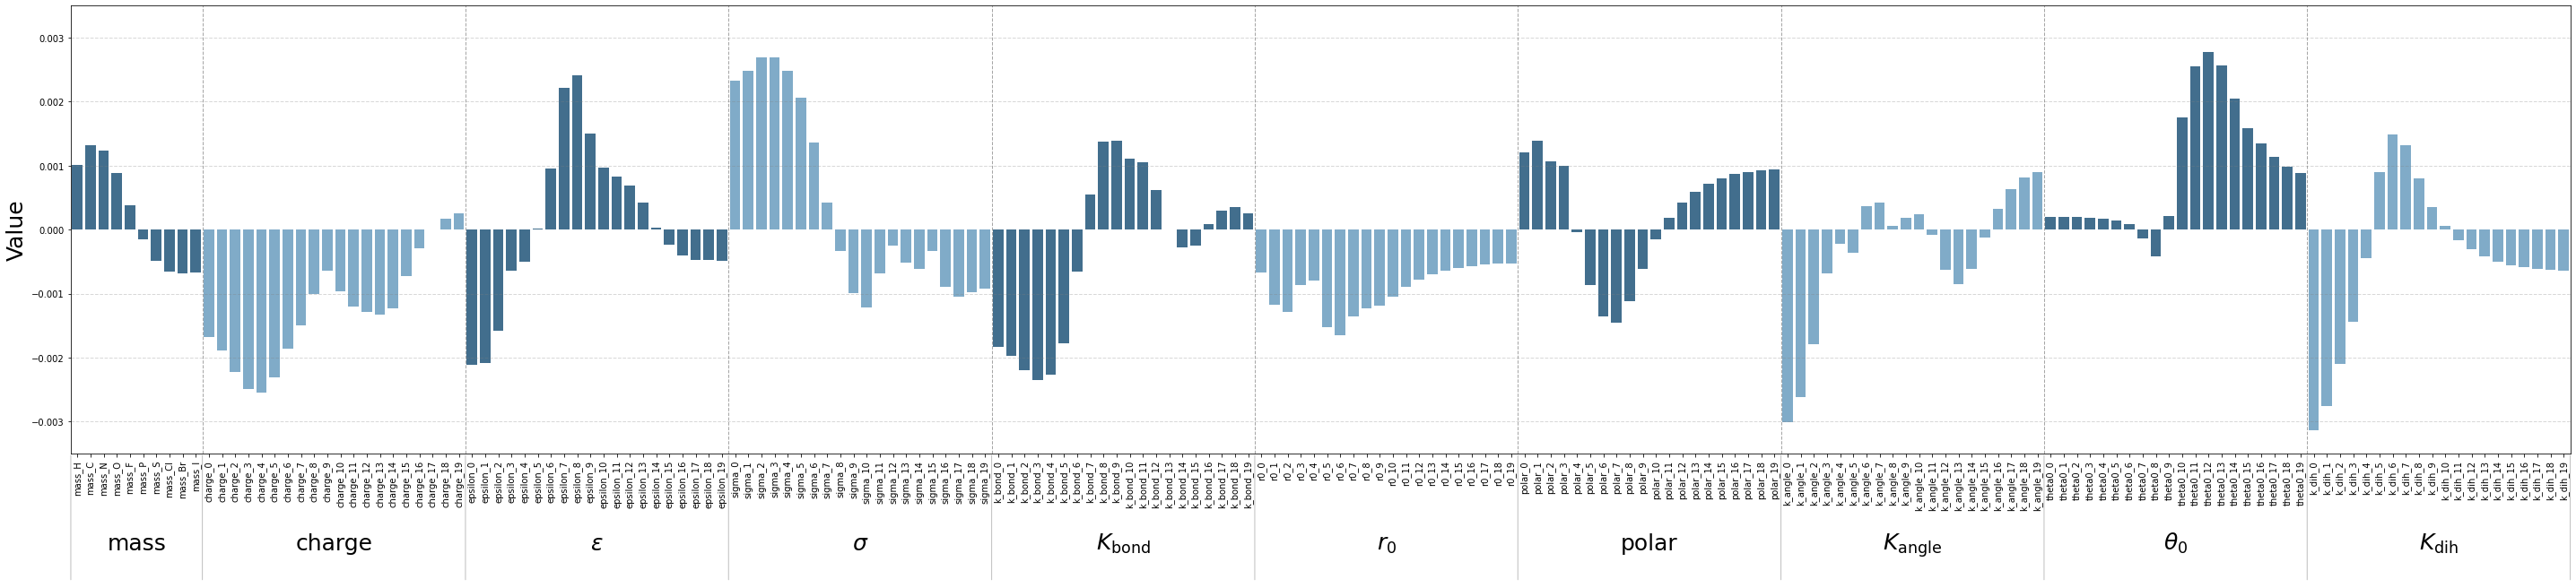

In [13]:
tmp = df_params_inv.iloc[:,4:].mean()
tmp2 = pd.DataFrame(tmp, columns=['Value'])
tmp2['Type'] = tmp.index.values
tmp3_inv = tmp2.sort_values(by='Value', ascending=False)

data_plt = df_params_inv.iloc[:,4:].melt()
data_plt['value_neg'] = data_plt['value']

fig, ax = plt.subplots(1, 1, figsize=(40, 10))
# plt.ylim(10, 40)
graph = sns.barplot(y='value_neg', x='variable', data=data_plt,ax=ax, ci=None, palette=col_palette)#color='steelblue')
list_vline = [9.5, 29.5, 49.5, 69.5, 89.5, 109.5, 129.5, 149.5, 169.5]
for i_vline in range(9):
    graph.axvline(list_vline[i_vline], alpha=0.7, color='gray', linestyle='--', linewidth=1)
for i_hline in [0.003, 0.002, 0.001, -0.001, -0.002, -0.003]:
    graph.axhline(i_hline, alpha=0.3, color='gray', linestyle='--', linewidth=1)
graph.set_ylim([-0.0035, 0.0035])
ax.set_ylabel('Value', size=25)
ax.set_xlabel('')

plt.text(4.5,   -0.005, 'mass', size=25, ha='center')
plt.text(19.5,  -0.005, 'charge', size=25, ha='center')
plt.text(39.5,  -0.005, r'$\epsilon$', size=25, ha='center')
plt.text(59.5,  -0.005, r'$\sigma$', size=25, ha='center')
plt.text(79.5,  -0.005, r'$K_{\rm bond}$', size=25, ha='center')
plt.text(99.5,  -0.005, r'$r_0$', size=25, ha='center')
plt.text(119.5, -0.005, 'polar', size=25, ha='center')
plt.text(139.5, -0.005, r'$K_{\rm angle}$', size=25, ha='center')
plt.text(159.5, -0.005, r'$\theta_0$', size=25, ha='center')
plt.text(179.5, -0.005, r'$K_{\rm dih}$', size=25, ha='center')

for line_x in [-0.5]+list_vline+[189.5]:
    plt.annotate('', xy=(line_x, -0.0035), xytext=(line_x, -0.0055), annotation_clip=False, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))
plt.xticks(rotation=90)
plt.tight_layout(rect=[0,0.1,1,1])
plt.savefig('../30_Output/20_Plot/400_MakeResult/434_Barplot_INV.pdf')